In [1]:
# Cell 1 — set CWD and imports
import os
os.chdir(r"C:\Users\Lavanya R\CircuitGuard_Project")
print("CWD:", os.getcwd())

# Common imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import itertools


CWD: C:\Users\Lavanya R\CircuitGuard_Project


C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 2 — load or create combined summary
batch_dir = Path("inference_results_module06_batch")
summary_path = batch_dir / "batch_detections_summary.csv"

if not summary_path.exists():
    # if not present, try the fast or resume folder
    alt = Path("inference_results_module06_batch_fast")
    if alt.exists():
        csvs = sorted(alt.glob("detections_*.csv"))
        if csvs:
            dfs = [pd.read_csv(f).assign(source_csv=f.name) for f in csvs]
            big = pd.concat(dfs, ignore_index=True)
            summary_path = batch_dir / "batch_detections_summary.csv"
            batch_dir.mkdir(exist_ok=True)
            big.to_csv(summary_path, index=False)
            print("Wrote combined summary to", summary_path)
    else:
        raise FileNotFoundError("batch_detections_summary.csv not found; run Module 06 batch or create summary first.")
else:
    print("Found summary:", summary_path)

df = pd.read_csv(summary_path)
print("Loaded rows:", len(df))
df.head(3)


Found summary: inference_results_module06_batch\batch_detections_summary.csv
Loaded rows: 3190


,image,roi_idx,x0,y0,x1,y1,label,score,source_csv
0,01_missing_hole_01.jpg,0,0,1539,2914,1784,Open_circuit,0.335092,detections_01_missing_hole_01.csv
1,01_missing_hole_01.jpg,1,235,11,3129,242,Spurious_copper,0.718036,detections_01_missing_hole_01.csv
2,01_missing_hole_01.jpg,2,0,11,298,1437,Short,0.740008,detections_01_missing_hole_01.csv


In [3]:
# Cell 3 — derive labels / mappings
# Use the classes folder names inside images as canonical labels
img_root = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\images")
classes = sorted([d.name for d in img_root.iterdir() if d.is_dir()])
print("Detected classes:", classes)

# normalise function
def infer_true_label_from_imagename(image_name, classes_list=classes):
    # common naming examples: 01_missing_hole_01.jpg or 01_missing_hole_01.JPG
    lname = image_name.lower()
    for cls in classes_list:
        if cls.lower() in lname:
            return cls
    # fallback: try substrings between underscores
    parts = image_name.lower().split("_")
    for p in parts:
        for cls in classes_list:
            if p == cls.lower():
                return cls
    return None

# quick sanity
for i in df["image"].unique()[:6]:
    print(i, "->", infer_true_label_from_imagename(i))


Detected classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
01_missing_hole_01.jpg -> Missing_hole
01_missing_hole_02.jpg -> Missing_hole
01_missing_hole_03.jpg -> Missing_hole
01_missing_hole_04.jpg -> Missing_hole
01_missing_hole_05.jpg -> Missing_hole
01_missing_hole_06.jpg -> Missing_hole


In [4]:
# Cell 4 — map predictions to canonical labels and build y_true/y_pred
df2 = df.copy()

# ensure label column exists (predicted label)
if "label" not in df2.columns:
    raise KeyError("Predicted 'label' column missing in summary CSV")

# infer true label for each row
df2["true_label"] = df2["image"].apply(lambda x: infer_true_label_from_imagename(x))
missing = df2["true_label"].isna().sum()
print("Rows with missing inferred true_label:", missing)
if missing > 0:
    # show examples
    display(df2[df2["true_label"].isna()].image.unique()[:10])

# restrict to rows with known true label
df_eval = df2[~df2["true_label"].isna()].copy()
print("Eval rows:", len(df_eval))

# normalize label strings (match classes)
# ensure predicted labels are in same capitalisation as classes
# attempt mapping by substring
def map_pred_label(pred):
    for cls in classes:
        if cls.lower() in str(pred).lower():
            return cls
    return str(pred)

df_eval["pred_label"] = df_eval["label"].apply(map_pred_label)

# lists
y_true = df_eval["true_label"].tolist()
y_pred = df_eval["pred_label"].tolist()


Rows with missing inferred true_label: 0
Eval rows: 3190


Using label order: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
Overall accuracy (per-ROI): 0.1438871473354232

Classification report (per-ROI):
                 precision    recall  f1-score   support

   Missing_hole       0.37      0.19      0.25      1150
     Mouse_bite       0.42      0.11      0.17      1150
   Open_circuit       0.27      0.13      0.18       890
          Short       0.00      0.00      0.00         0
           Spur       0.00      0.00      0.00         0
Spurious_copper       0.00      0.00      0.00         0

       accuracy                           0.14      3190
      macro avg       0.18      0.07      0.10      3190
   weighted avg       0.36      0.14      0.20      3190



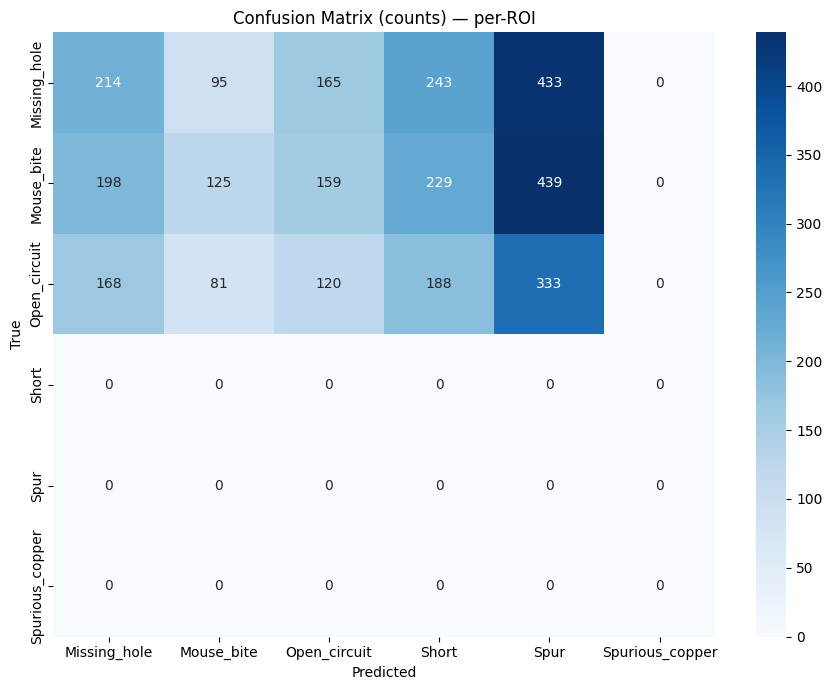

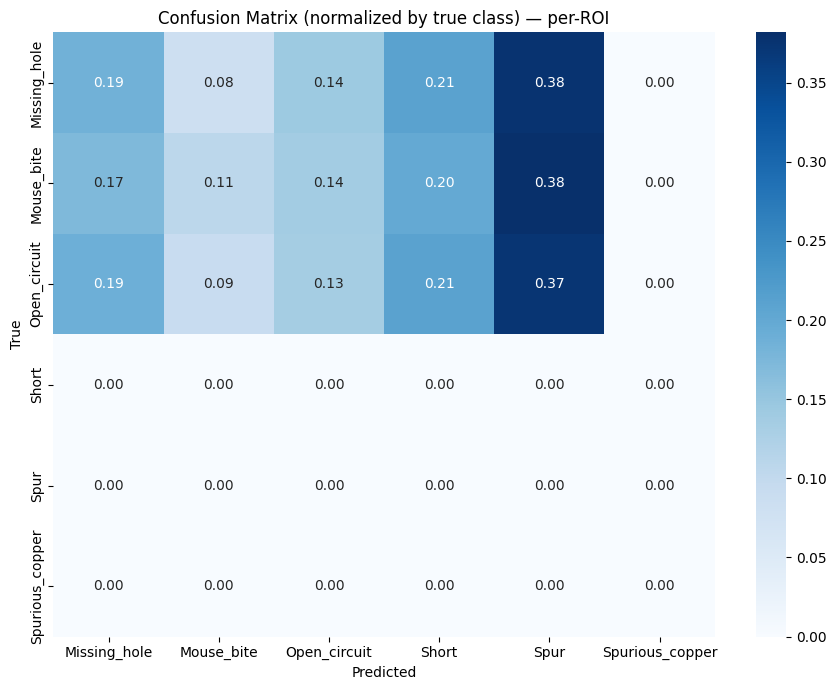

In [5]:
# Cell 5 — metrics per ROI
labels = classes  # use canonical order from dataset
print("Using label order:", labels)

acc = accuracy_score(y_true, y_pred)
print("Overall accuracy (per-ROI):", acc)

print("\nClassification report (per-ROI):")
print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

# plot confusion matrix
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (counts) — per-ROI")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized by true class) — per-ROI")
plt.tight_layout()
plt.show()


In [6]:
# Cell 6 — per-image majority-vote evaluation
# For each image, pick the predicted class with highest avg score or majority of ROI votes
grouped = df_eval.groupby("image")
rows = []
for image_name, g in grouped:
    # try score-weighted vote
    if "score" in g.columns:
        # weighted by score: sum scores per predicted label
        vote = g.groupby("pred_label")["score"].sum()
        pred = vote.idxmax()
    else:
        pred = g["pred_label"].mode().iat[0]
    true = g["true_label"].iloc[0]
    rows.append({"image": image_name, "true": true, "pred": pred})
img_df = pd.DataFrame(rows)
print("Images evaluated:", len(img_df))
acc_img = (img_df["true"] == img_df["pred"]).mean()
print("Overall image-level accuracy:", acc_img)
display(img_df.head())
print("\nImage-level classification report:")
print(classification_report(img_df["true"], img_df["pred"], labels=labels, zero_division=0))


Images evaluated: 319
Overall image-level accuracy: 0.09404388714733543


,image,true,pred
0,01_missing_hole_01.jpg,Missing_hole,Spur
1,01_missing_hole_02.jpg,Missing_hole,Short
2,01_missing_hole_03.jpg,Missing_hole,Spur
3,01_missing_hole_04.jpg,Missing_hole,Spur
4,01_missing_hole_05.jpg,Missing_hole,Spur



Image-level classification report:
                 precision    recall  f1-score   support

   Missing_hole       0.41      0.10      0.15       115
     Mouse_bite       0.62      0.11      0.19       115
   Open_circuit       0.25      0.07      0.11        89
          Short       0.00      0.00      0.00         0
           Spur       0.00      0.00      0.00         0
Spurious_copper       0.00      0.00      0.00         0

       accuracy                           0.09       319
      macro avg       0.21      0.05      0.08       319
   weighted avg       0.44      0.09      0.15       319



In [7]:
# Cell 7 — save CSV and confusion images
out_eval = Path("module07_evaluation")
out_eval.mkdir(exist_ok=True)

# save csvs
df_eval.to_csv(out_eval / "detections_per_roi_with_true.csv", index=False)
img_df.to_csv(out_eval / "detections_per_image_summary.csv", index=False)

# save confusion matrix images
import matplotlib
matplotlib.use("Agg")
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix (counts) — per-ROI")
plt.tight_layout()
plt.savefig(out_eval / "confusion_counts.png", dpi=200)
plt.close()

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix (normalized) — per-ROI")
plt.tight_layout()
plt.savefig(out_eval / "confusion_norm.png", dpi=200)
plt.close()

print("Saved evaluation artifacts to:", out_eval)


Saved evaluation artifacts to: module07_evaluation


In [8]:
# Cell 8 — export model to TorchScript (safe CPU tracing)
# NOTE: checkpoint must contain model_state and label2idx as used previously.
ckpt = Path("checkpoints/best_effnet_b0_cpu.pth")  # or ultrafast one
if not ckpt.exists():
    raise FileNotFoundError("Checkpoint not found: " + str(ckpt))

device = torch.device("cpu")
ck = torch.load(str(ckpt), map_location=device)
if "model_state" in ck:
    label2idx = ck.get("label2idx", None)
    num_classes = len(label2idx) if label2idx else ck["model_state"].next(iter(ck["model_state"].values())).shape[0] if False else None
    # create model same as during training
    model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=len(label2idx) if label2idx else 6)
    model.load_state_dict(ck["model_state"])
    model.eval().to(device)

    # create a sample input tensor matching your backend size
    sample = torch.randn(1, 3, 224, 224)  # match image size used in training/inference
    try:
        traced = torch.jit.trace(model.cpu(), sample, check_trace=False)
        ts_path = Path("checkpoints") / "effnet_b0_cpu_traced.pt"
        traced.save(str(ts_path))
        print("Saved TorchScript model to:", ts_path)
    except Exception as e:
        print("TorchScript trace failed:", e)
else:
    raise RuntimeError("Checkpoint does not have 'model_state' key.")


Saved TorchScript model to: checkpoints\effnet_b0_cpu_traced.pt


In [9]:
# Cell 9 — write a short module7 summary file
from pathlib import Path
out_eval = Path("module07_evaluation")
out_eval.mkdir(exist_ok=True)
report_txt = out_eval / "README_MODULE07.txt"

with open(report_txt, "w", encoding="utf-8") as f:
    f.write("Module 07 Evaluation Report\n")
    f.write("==========================\n")
    f.write(f"Total detection rows: {len(df_eval)}\n")
    f.write(f"Unique images evaluated: {len(img_df)}\n")
    f.write(f"Per-ROI overall accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
    f.write(f"Per-image overall accuracy: {acc_img:.4f}\n")
    f.write("\nPredicted label counts:\n")
    f.write(df_eval['pred_label'].value_counts().to_string())
    f.write("\n\nRefer to confusion matrices and CSVs in this folder.\n")
print("Wrote report to:", report_txt)


Wrote report to: module07_evaluation\README_MODULE07.txt
